In [1]:
# ======================================
# Complete Preprocessing + Train/Test Handling (Combined Snippet)
# ======================================

import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, Model


# -----------------------------
# 1️⃣ Load Data
# -----------------------------
train_csv = "/kaggle/input/airs-ai-in-respiratory-sounds/train.csv"
test_csv  = "/kaggle/input/airs-ai-in-respiratory-sounds/test.csv"
audio_path = "/kaggle/input/airs-ai-in-respiratory-sounds/sounds/sounds"

train_df = pd.read_csv(train_csv)
test_df  = pd.read_csv(test_csv)

tab_features = ['age', 'gender', 'tbContactHistory', 'wheezingHistory', 'phlegmCough',
                'familyAsthmaHistory', 'feverHistory', 'coldPresent', 'packYears']

# -----------------------------
# 2️⃣ Map audio files
# -----------------------------
file_map = {}
for folder in os.listdir(audio_path):
    fpath = os.path.join(audio_path, folder)
    if os.path.isdir(fpath):
        wavs = [f for f in os.listdir(fpath) if f.endswith(".wav")]
        if wavs:
            file_map[folder] = os.path.join(fpath, wavs[0])

# -----------------------------
# 3️⃣ MFCC Extraction Function
# -----------------------------
def extract_mfcc_features(file_path, n_mfcc=40, duration=5, sr=22050):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_scaled = np.mean(mfcc.T, axis=0)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_scaled = np.mean(chroma.T, axis=0)
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_scaled = np.mean(mel.T, axis=0)
        features = np.hstack([mfcc_scaled, chroma_scaled, mel_scaled])
        return features
    except:
        return np.zeros(n_mfcc + 12 + 128)

# -----------------------------
# 4️⃣ Extract features for train
# -----------------------------
X_audio = []
valid_ids = []
for i, cid in enumerate(train_df['candidateID']):
    if cid in file_map:
        X_audio.append(extract_mfcc_features(file_map[cid]))
        valid_ids.append(cid)
X_audio = np.array(X_audio)

df = train_df[train_df['candidateID'].isin(valid_ids)]
X_tab = df[tab_features].values
y = df['disease'].values

# -----------------------------
# 5️⃣ Extract features for test
# -----------------------------
X_audio_test = []
for i, cid in enumerate(test_df['candidateID']):
    if cid in file_map:
        X_audio_test.append(extract_mfcc_features(file_map[cid]))
X_audio_test = np.array(X_audio_test)
X_tab_test = test_df[tab_features].values

# -----------------------------
# 6️⃣ Iterative Imputation + Scaling (Train + Test)
# -----------------------------
iterative_imputer = IterativeImputer(
    max_iter=10,
    random_state=42,
    estimator=RandomForestClassifier(n_estimators=50, random_state=42)
)
X_tab_iterative = iterative_imputer.fit_transform(X_tab)
X_tab_test_iterative = iterative_imputer.transform(X_tab_test)  # apply same imputer

scaler_tab = StandardScaler()
X_tab_scaled = scaler_tab.fit_transform(X_tab_iterative)
X_tab_scaled_test = scaler_tab.transform(X_tab_test_iterative)

# -----------------------------
# 7️⃣ Train-validation split
# -----------------------------
X_tab_train, X_tab_val, X_audio_train, X_audio_val, y_train, y_val = train_test_split(
    X_tab_scaled, X_audio, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

# Reshape audio for model
X_audio_train = X_audio_train.reshape(X_audio_train.shape[0], X_audio_train.shape[1], 1)
X_audio_val = X_audio_val.reshape(X_audio_val.shape[0], X_audio_val.shape[1], 1)
X_audio_test_fixed = X_audio_test.reshape(X_audio_test.shape[0], X_audio_test.shape[1], 1)

# -----------------------------
# 8️⃣ Class Weights
# -----------------------------
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# -----------------------------
# 9️⃣ Flatten MFCC for augmentation (Train only)
# -----------------------------
X_mel_2d = X_audio_train.reshape(X_audio_train.shape[0], -1)
X_tab_mel = X_tab_train
y_mel = y_train

def advanced_flat_augmentation(feature_vector):
    augmented = feature_vector.copy()
    if np.random.random() > 0.5:
        augmented += np.random.normal(0, 0.01, augmented.shape)
    if np.random.random() > 0.5:
        augmented = np.roll(augmented, np.random.randint(-5,5))
    return augmented

X_mel_augmented = []
X_tab_augmented = []
y_augmented = []

# Original train data
X_mel_augmented.extend(X_mel_2d)
X_tab_augmented.extend(X_tab_mel)
y_augmented.extend(y_mel)

# Augmented data (3x)
for i in range(len(X_mel_2d)):
    for _ in range(3):
        aug_mel = advanced_flat_augmentation(X_mel_2d[i])
        X_mel_augmented.append(aug_mel)
        X_tab_augmented.append(X_tab_mel[i])
        y_augmented.append(y_mel[i])

X_mel_augmented = np.array(X_mel_augmented)
X_tab_augmented = np.array(X_tab_augmented)
y_augmented = np.array(y_augmented)

print("✅ Preprocessing complete! Ready for training + testing.")
print(f"Train samples (augmented): {len(X_mel_augmented)}, Test samples: {X_audio_test_fixed.shape[0]}")


2025-12-07 17:49:35.135455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765129775.343883      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765129775.403112      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


✅ Preprocessing complete! Ready for training + testing.
Train samples (augmented): 1856, Test samples: 338


In [2]:
# -----------------------------
# 7️⃣ Train-validation split (85% train, 15% validation)
# -----------------------------
X_tab_train, X_tab_val, X_audio_train, X_audio_val, y_train, y_val = train_test_split(
    X_tab_scaled, X_audio, y,
    test_size=0.15,       # 15% for validation
    stratify=y,
    random_state=42
)

# Reshape audio for model
X_audio_train = X_audio_train.reshape(X_audio_train.shape[0], X_audio_train.shape[1], 1)
X_audio_val = X_audio_val.reshape(X_audio_val.shape[0], X_audio_val.shape[1], 1)
X_audio_test_fixed = X_audio_test.reshape(X_audio_test.shape[0], X_audio_test.shape[1], 1)

print(f"✅ Training samples: {X_audio_train.shape[0]}, Validation samples: {X_audio_val.shape[0]}, Test samples: {X_audio_test_fixed.shape[0]}")


✅ Training samples: 464, Validation samples: 82, Test samples: 338


✅ Flattened MFCC features: Train (1577, 180), Val (279, 180)


I0000 00:00:1765129852.706262      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


✅ Model created and compiled!


Model: "fixed_super_advanced_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pretrained_features │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │    185,344 │ pretrained_featu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024)      │      4,096 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │      2,560 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 320)       │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │    164,352 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_6[0][0]   

 Total params: 1,566,019 (5.97 MB)

 Trainable params: 1,558,339 (5.94 MB)

 Non-trainable params: 7,680 (30.00 KB)

✅ Class weights: {0: 1.301155115511551, 1: 0.7651625424551188, 2: 1.0816186556927299}
Epoch 1/300


I0000 00:00:1765129860.530235     114 service.cc:148] XLA service 0x7e08cc002aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765129860.530666     114 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765129861.549182     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


39/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3084 - loss: 1.4424

I0000 00:00:1765129867.367557     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3155 - loss: 1.4108
Epoch 1: val_accuracy improved from -inf to 0.28674, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.3155 - loss: 1.4105 - val_accuracy: 0.2867 - val_loss: 1.1573 - learning_rate: 1.0000e-04
Epoch 2/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3378 - loss: 1.3088
Epoch 2: val_accuracy improved from 0.28674 to 0.34767, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3386 - loss: 1.3082 - val_accuracy: 0.3477 - val_loss: 1.1192 - learning_rate: 1.0000e-04
Epoch 3/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3367 - loss: 1.3227
Epoch 3: val_accuracy improved from 0.34767 to 0.41935, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3371 - loss: 1.3217 - val_accuracy: 0.4194 - val_loss: 1.0777 - learning_rate: 1.0000e-04
Epoch 4/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4022 - loss: 1.1964
Epoch 4: val_accuracy did not improve from 0.41935
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4015 - loss: 1.1973 - val_accuracy: 0.4050 - val_loss: 1.0677 - learning_rate: 1.0000e-04
Epoch 5/300
94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3820 - loss: 1.2144
Epoch 5: val_accuracy improved from 0.41935 to 0.44086, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3822 - loss: 1.2136 - val_accuracy: 0.4409 - val_loss: 1.0426 - learning_rate: 1.0000e-04
Epoch 6/300
93/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3828 - loss: 1.1806
Epoch 6: val_accuracy improved from 0.44086 to 0.50538, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3834 - loss: 1.1799 - val_accuracy: 0.5054 - val_loss: 1.0010 - learning_rate: 1.0000e-04
Epoch 7/300
94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4137 - loss: 1.1636
Epoch 7: val_accuracy improved from 0.50538 to 0.59140, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4146 - loss: 1.1614 - val_accuracy: 0.5914 - val_loss: 0.9451 - learning_rate: 1.0000e-04
Epoch 8/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4142 - loss: 1.1085
Epoch 8: val_accuracy did not improve from 0.59140
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4147 - loss: 1.1089 - val_accuracy: 0.5878 - val_loss: 0.9216 - learning_rate: 1.0000e-04
Epoch 9/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4710 - loss: 1.0690
Epoch 9: val_accuracy improved from 0.59140 to 0.64875, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4711 - loss: 1.0671 - val_accuracy: 0.6487 - val_loss: 0.8604 - learning_rate: 1.0000e-04
Epoch 10/300
93/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4993 - loss: 1.0290
Epoch 10: val_accuracy improved from 0.64875 to 0.66667, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4990 - loss: 1.0290 - val_accuracy: 0.6667 - val_loss: 0.8021 - learning_rate: 1.0000e-04
Epoch 11/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5471 - loss: 0.9605
Epoch 11: val_accuracy did not improve from 0.66667
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5472 - loss: 0.9611 - val_accuracy: 0.6452 - val_loss: 0.7936 - learning_rate: 1.0000e-04
Epoch 12/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5287 - loss: 0.9891
Epoch 12: val_accuracy did not improve from 0.66667
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5288 - loss: 0.9888 - val_accuracy: 0.6667 - val_loss: 0.7548 - learning_rate: 1.0000e-04
Epoch 13/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5623 - loss: 0.9012
Epoch 13: val_accuracy improved from 0.66667 to 0.69892, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5628 - loss: 0.9004 - val_accuracy: 0.6989 - val_loss: 0.7071 - learning_rate: 1.0000e-04
Epoch 14/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6320 - loss: 0.8399
Epoch 14: val_accuracy improved from 0.69892 to 0.71326, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6317 - loss: 0.8404 - val_accuracy: 0.7133 - val_loss: 0.6854 - learning_rate: 1.0000e-04
Epoch 15/300
93/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6479 - loss: 0.8390
Epoch 15: val_accuracy improved from 0.71326 to 0.72043, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6476 - loss: 0.8381 - val_accuracy: 0.7204 - val_loss: 0.6619 - learning_rate: 1.0000e-04
Epoch 16/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6420 - loss: 0.7815
Epoch 16: val_accuracy improved from 0.72043 to 0.72760, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6426 - loss: 0.7806 - val_accuracy: 0.7276 - val_loss: 0.6458 - learning_rate: 1.0000e-04
Epoch 17/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6737 - loss: 0.7722
Epoch 17: val_accuracy did not improve from 0.72760
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6738 - loss: 0.7717 - val_accuracy: 0.7276 - val_loss: 0.6470 - learning_rate: 1.0000e-04
Epoch 18/300
93/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6545 - loss: 0.7483
Epoch 18: val_accuracy improved from 0.72760 to 0.73477, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6568 - loss: 0.7473 - val_accuracy: 0.7348 - val_loss: 0.6371 - learning_rate: 1.0000e-04
Epoch 19/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7155 - loss: 0.6818
Epoch 19: val_accuracy improved from 0.73477 to 0.74194, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7153 - loss: 0.6828 - val_accuracy: 0.7419 - val_loss: 0.6180 - learning_rate: 1.0000e-04
Epoch 20/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7213 - loss: 0.7310
Epoch 20: val_accuracy improved from 0.74194 to 0.75269, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7221 - loss: 0.7271 - val_accuracy: 0.7527 - val_loss: 0.6120 - learning_rate: 1.0000e-04
Epoch 21/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7390 - loss: 0.6665
Epoch 21: val_accuracy improved from 0.75269 to 0.76703, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7375 - loss: 0.6674 - val_accuracy: 0.7670 - val_loss: 0.5999 - learning_rate: 1.0000e-04
Epoch 22/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7342 - loss: 0.6936
Epoch 22: val_accuracy improved from 0.76703 to 0.77061, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7339 - loss: 0.6920 - val_accuracy: 0.7706 - val_loss: 0.5786 - learning_rate: 1.0000e-04
Epoch 23/300
93/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7467 - loss: 0.6446
Epoch 23: val_accuracy did not improve from 0.77061
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7461 - loss: 0.6469 - val_accuracy: 0.7634 - val_loss: 0.5867 - learning_rate: 1.0000e-04
Epoch 24/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7287 - loss: 0.6891
Epoch 24: val_accuracy did not improve from 0.77061
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7299 - loss: 0.6876 - val_accuracy: 0.7670 - val_loss: 0.5811 - learning_rate: 1.0000e-04
Epoch 25/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7503 - loss: 0.6361
Epoch 25: val_accuracy improved from 0.77061 to 0.77778, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7502 - loss: 0.6369 - val_accuracy: 0.7778 - val_loss: 0.5668 - learning_rate: 1.0000e-04
Epoch 26/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7559 - loss: 0.6617
Epoch 26: val_accuracy did not improve from 0.77778
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7563 - loss: 0.6584 - val_accuracy: 0.7778 - val_loss: 0.5678 - learning_rate: 1.0000e-04
Epoch 27/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7556 - loss: 0.6295
Epoch 27: val_accuracy did not improve from 0.77778
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7563 - loss: 0.6271 - val_accuracy: 0.7778 - val_loss: 0.5639 - learning_rate: 1.0000e-04
Epoch 28/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7560 - loss: 0.6420
Epoch 28: val_accuracy improved from 0.77778 to 0.78495, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7557 - loss: 0.6409 - val_accuracy: 0.7849 - val_loss: 0.5488 - learning_rate: 1.0000e-04
Epoch 29/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7440 - loss: 0.6408
Epoch 29: val_accuracy did not improve from 0.78495
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7457 - loss: 0.6383 - val_accuracy: 0.7849 - val_loss: 0.5442 - learning_rate: 1.0000e-04
Epoch 30/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7688 - loss: 0.6240
Epoch 30: val_accuracy improved from 0.78495 to 0.79570, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7688 - loss: 0.6240 - val_accuracy: 0.7957 - val_loss: 0.5361 - learning_rate: 1.0000e-04
Epoch 31/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7660 - loss: 0.6197
Epoch 31: val_accuracy did not improve from 0.79570
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7663 - loss: 0.6192 - val_accuracy: 0.7957 - val_loss: 0.5444 - learning_rate: 1.0000e-04
Epoch 32/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7400 - loss: 0.6788
Epoch 32: val_accuracy did not improve from 0.79570
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7417 - loss: 0.6754 - val_accuracy: 0.7921 - val_loss: 0.5405 - learning_rate: 1.0000e-04
Epoch 33/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7506 - loss: 0.6191
Epoch 33: val_accuracy improved from 0.79570 to 0.80645, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7528 - loss: 0.6152 - val_accuracy: 0.8065 - val_loss: 0.5396 - learning_rate: 1.0000e-04
Epoch 34/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7799 - loss: 0.5354
Epoch 34: val_accuracy did not improve from 0.80645
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7798 - loss: 0.5376 - val_accuracy: 0.8065 - val_loss: 0.5369 - learning_rate: 1.0000e-04
Epoch 35/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7767 - loss: 0.5845
Epoch 35: val_accuracy did not improve from 0.80645
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7770 - loss: 0.5838 - val_accuracy: 0.8029 - val_loss: 0.5341 - learning_rate: 1.0000e-04
Epoch 36/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7771 - loss: 0.5680
Epoch 36: val_accuracy did not improve from 0.80645
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7773 - loss: 0.5681 - val_accuracy: 0.8065 - val_loss: 0.5338 - learning_rate: 1.0000e-04
Epoch 37/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7719 - loss: 0.6048 - val_accuracy: 0.8100 - val_loss: 0.5311 - learning_rate: 1.0000e-04
Epoch 38/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7682 - loss: 0.5858
Epoch 38: val_accuracy did not improve from 0.81004
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7694 - loss: 0.5839 - val_accuracy: 0.8100 - val_loss: 0.5198 - learning_rate: 1.0000e-04
Epoch 39/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7679 - loss: 0.5598
Epoch 39: val_accuracy did not improve from 0.81004
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7682 - loss: 0.5598 - val_accuracy: 0.8029 - val_loss: 0.5213 - learning_rate: 1.0000e-04
Epoch 40/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7947 - loss: 0.5303
Epoch 40: val_accuracy did not improve from 0.81004
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7941 - loss: 0.5315 - val_accuracy: 0.8100 - val_loss: 0.5177 - learning_rate: 1.0000e-04
Epoch 41/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7818 - loss: 0.5169 - val_accuracy: 0.8208 - val_loss: 0.5069 - learning_rate: 1.0000e-04
Epoch 43/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7851 - loss: 0.5667
Epoch 43: val_accuracy did not improve from 0.82079
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7855 - loss: 0.5646 - val_accuracy: 0.8208 - val_loss: 0.5061 - learning_rate: 1.0000e-04
Epoch 44/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7953 - loss: 0.5574
Epoch 44: val_accuracy improved from 0.82079 to 0.82437, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7945 - loss: 0.5558 - val_accuracy: 0.8244 - val_loss: 0.5053 - learning_rate: 1.0000e-04
Epoch 45/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8066 - loss: 0.5155
Epoch 45: val_accuracy improved from 0.82437 to 0.83871, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8063 - loss: 0.5156 - val_accuracy: 0.8387 - val_loss: 0.4999 - learning_rate: 1.0000e-04
Epoch 46/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7967 - loss: 0.5362
Epoch 46: val_accuracy did not improve from 0.83871
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7972 - loss: 0.5354 - val_accuracy: 0.8280 - val_loss: 0.4992 - learning_rate: 1.0000e-04
Epoch 47/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8018 - loss: 0.5101
Epoch 47: val_accuracy did not improve from 0.83871
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8007 - loss: 0.5117 - val_accuracy: 0.8172 - val_loss: 0.5014 - learning_rate: 1.0000e-04
Epoch 48/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8008 - loss: 0.5215
Epoch 48: val_accuracy did not improve from 0.83871
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8014 - loss: 0.5206 - val_accuracy: 0.8244 - val_loss: 0.5024 - learning_rate: 1.0000e-04
Epoch 49/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8380 - loss: 0.4200 - val_accuracy: 0.8423 - val_loss: 0.4343 - learning_rate: 5.0000e-05
Epoch 70/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8259 - loss: 0.4502
Epoch 70: val_accuracy did not improve from 0.84229
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8258 - loss: 0.4501 - val_accuracy: 0.8387 - val_loss: 0.4328 - learning_rate: 5.0000e-05
Epoch 71/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8366 - loss: 0.4345
Epoch 71: val_accuracy did not improve from 0.84229
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8367 - loss: 0.4343 - val_accuracy: 0.8387 - val_loss: 0.4284 - learning_rate: 5.0000e-05
Epoch 72/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8150 - loss: 0.4561
Epoch 72: val_accuracy did not improve from 0.84229
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8148 - loss: 0.4576 - val_accuracy: 0.8387 - val_loss: 0.4322 - learning_rate: 5.0000e-05
Epoch 73/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8429 - loss: 0.3891 - val_accuracy: 0.8459 - val_loss: 0.4186 - learning_rate: 5.0000e-05
Epoch 87/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8312 - loss: 0.4267
Epoch 87: val_accuracy did not improve from 0.84588
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8312 - loss: 0.4251 - val_accuracy: 0.8280 - val_loss: 0.4120 - learning_rate: 5.0000e-05
Epoch 88/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8376 - loss: 0.4244
Epoch 88: val_accuracy did not improve from 0.84588
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8377 - loss: 0.4236 - val_accuracy: 0.8280 - val_loss: 0.4211 - learning_rate: 5.0000e-05
Epoch 89/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8533 - loss: 0.3814
Epoch 89: val_accuracy did not improve from 0.84588
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8527 - loss: 0.3822 - val_accuracy: 0.8351 - val_loss: 0.4169 - learning_rate: 5.0000e-05
Epoch 90/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8398 - loss: 0.3805 - val_accuracy: 0.8495 - val_loss: 0.3955 - learning_rate: 5.0000e-05
Epoch 99/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8656 - loss: 0.3706
Epoch 99: val_accuracy did not improve from 0.84946
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8637 - loss: 0.3720 - val_accuracy: 0.8423 - val_loss: 0.3957 - learning_rate: 5.0000e-05
Epoch 100/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8589 - loss: 0.3684
Epoch 100: val_accuracy did not improve from 0.84946
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8579 - loss: 0.3703 - val_accuracy: 0.8351 - val_loss: 0.3946 - learning_rate: 5.0000e-05
Epoch 101/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8433 - loss: 0.4002
Epoch 101: val_accuracy did not improve from 0.84946
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8441 - loss: 0.3970 - val_accuracy: 0.8423 - val_loss: 0.3954 - learning_rate: 5.0000e-05
Epoch 102/

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8432 - loss: 0.3997 - val_accuracy: 0.8530 - val_loss: 0.3861 - learning_rate: 5.0000e-05
Epoch 105/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8513 - loss: 0.3680
Epoch 105: val_accuracy improved from 0.85305 to 0.86022, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8518 - loss: 0.3667 - val_accuracy: 0.8602 - val_loss: 0.3873 - learning_rate: 5.0000e-05
Epoch 106/300
94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8609 - loss: 0.3746
Epoch 106: val_accuracy did not improve from 0.86022
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8608 - loss: 0.3736 - val_accuracy: 0.8602 - val_loss: 0.3819 - learning_rate: 5.0000e-05
Epoch 107/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8518 - loss: 0.3599
Epoch 107: val_accuracy did not improve from 0.86022
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8522 - loss: 0.3602 - val_accuracy: 0.8530 - val_loss: 0.3803 - learning_rate: 5.0000e-05
Epoch 108/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8688 - loss: 0.3273
Epoch 108: val_accuracy did not improve from 0.86022
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8677 - loss: 0.3301 - val_accuracy: 0.8602 - val_loss: 0.3749 - learning_rate: 5.0000e-05
Epoch 10

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8657 - loss: 0.3333 - val_accuracy: 0.8710 - val_loss: 0.3665 - learning_rate: 5.0000e-05
Epoch 113/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8688 - loss: 0.3260
Epoch 113: val_accuracy improved from 0.87097 to 0.87455, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8669 - loss: 0.3292 - val_accuracy: 0.8746 - val_loss: 0.3661 - learning_rate: 5.0000e-05
Epoch 114/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8618 - loss: 0.3380
Epoch 114: val_accuracy did not improve from 0.87455
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8618 - loss: 0.3377 - val_accuracy: 0.8710 - val_loss: 0.3665 - learning_rate: 5.0000e-05
Epoch 115/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8686 - loss: 0.3334
Epoch 115: val_accuracy did not improve from 0.87455
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8684 - loss: 0.3339 - val_accuracy: 0.8746 - val_loss: 0.3643 - learning_rate: 5.0000e-05
Epoch 116/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8667 - loss: 0.3226
Epoch 116: val_accuracy did not improve from 0.87455
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8666 - loss: 0.3230 - val_accuracy: 0.8710 - val_loss: 0.3653 - learning_rate: 5.0000e-05
Epoch 11

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8689 - loss: 0.3161 - val_accuracy: 0.8781 - val_loss: 0.3632 - learning_rate: 5.0000e-05
Epoch 121/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8712 - loss: 0.3495
Epoch 121: val_accuracy improved from 0.87814 to 0.88172, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8705 - loss: 0.3473 - val_accuracy: 0.8817 - val_loss: 0.3618 - learning_rate: 5.0000e-05
Epoch 122/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8455 - loss: 0.4064
Epoch 122: val_accuracy did not improve from 0.88172
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8478 - loss: 0.3995 - val_accuracy: 0.8817 - val_loss: 0.3674 - learning_rate: 5.0000e-05
Epoch 123/300
93/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8691 - loss: 0.3305
Epoch 123: val_accuracy did not improve from 0.88172
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8691 - loss: 0.3308 - val_accuracy: 0.8817 - val_loss: 0.3642 - learning_rate: 5.0000e-05
Epoch 124/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8802 - loss: 0.3046
Epoch 124: val_accuracy did not improve from 0.88172
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8780 - loss: 0.3078 - val_accuracy: 0.8817 - val_loss: 0.3599 - learning_rate: 5.0000e-05
Epoch 12

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8663 - loss: 0.3035 - val_accuracy: 0.8889 - val_loss: 0.3470 - learning_rate: 5.0000e-05
Epoch 136/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8761 - loss: 0.3054
Epoch 136: val_accuracy did not improve from 0.88889
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8766 - loss: 0.3053 - val_accuracy: 0.8817 - val_loss: 0.3497 - learning_rate: 5.0000e-05
Epoch 137/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8797 - loss: 0.3054
Epoch 137: val_accuracy did not improve from 0.88889
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8795 - loss: 0.3060 - val_accuracy: 0.8817 - val_loss: 0.3398 - learning_rate: 5.0000e-05
Epoch 138/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8745 - loss: 0.3039
Epoch 138: val_accuracy did not improve from 0.88889
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8742 - loss: 0.3045 - val_accuracy: 0.8853 - val_loss: 0.3360 - learning_rate: 5.0000e-05
Epoch 13

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8978 - loss: 0.2434 - val_accuracy: 0.8925 - val_loss: 0.3156 - learning_rate: 2.5000e-05
Epoch 172/300
93/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8922 - loss: 0.2590
Epoch 172: val_accuracy did not improve from 0.89247
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8914 - loss: 0.2606 - val_accuracy: 0.8889 - val_loss: 0.3162 - learning_rate: 2.5000e-05
Epoch 173/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8865 - loss: 0.2703
Epoch 173: val_accuracy did not improve from 0.89247
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8865 - loss: 0.2703 - val_accuracy: 0.8889 - val_loss: 0.3133 - learning_rate: 2.5000e-05
Epoch 174/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9013 - loss: 0.2528
Epoch 174: val_accuracy did not improve from 0.89247
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9017 - loss: 0.2528 - val_accuracy: 0.8817 - val_loss: 0.3105 - learning_rate: 2.5000e-05
Epoch 17

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8901 - loss: 0.2781 - val_accuracy: 0.8961 - val_loss: 0.3083 - learning_rate: 2.5000e-05
Epoch 176/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8798 - loss: 0.2925
Epoch 176: val_accuracy did not improve from 0.89606
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8799 - loss: 0.2924 - val_accuracy: 0.8961 - val_loss: 0.3101 - learning_rate: 2.5000e-05
Epoch 177/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9235 - loss: 0.2282
Epoch 177: val_accuracy did not improve from 0.89606
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9208 - loss: 0.2320 - val_accuracy: 0.8961 - val_loss: 0.3094 - learning_rate: 2.5000e-05
Epoch 178/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8769 - loss: 0.3155
Epoch 178: val_accuracy did not improve from 0.89606
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8784 - loss: 0.3123 - val_accuracy: 0.8961 - val_loss: 0.3012 - learning_rate: 2.5000e-05
Epoch 17

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8759 - loss: 0.3081 - val_accuracy: 0.8996 - val_loss: 0.3055 - learning_rate: 2.5000e-05
Epoch 186/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8932 - loss: 0.3149
Epoch 186: val_accuracy did not improve from 0.89964
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8930 - loss: 0.3143 - val_accuracy: 0.8925 - val_loss: 0.3053 - learning_rate: 2.5000e-05
Epoch 187/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8821 - loss: 0.3010
Epoch 187: val_accuracy did not improve from 0.89964
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8834 - loss: 0.2982 - val_accuracy: 0.8996 - val_loss: 0.3069 - learning_rate: 2.5000e-05
Epoch 188/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8907 - loss: 0.2433
Epoch 188: val_accuracy did not improve from 0.89964
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8906 - loss: 0.2441 - val_accuracy: 0.8996 - val_loss: 0.3055 - learning_rate: 2.5000e-05
Epoch 18

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9073 - loss: 0.2440 - val_accuracy: 0.9032 - val_loss: 0.3042 - learning_rate: 2.5000e-05
Epoch 198/300
87/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9083 - loss: 0.2330
Epoch 198: val_accuracy did not improve from 0.90323
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9088 - loss: 0.2317 - val_accuracy: 0.9032 - val_loss: 0.3016 - learning_rate: 2.5000e-05
Epoch 199/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8989 - loss: 0.2239
Epoch 199: val_accuracy did not improve from 0.90323
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8989 - loss: 0.2254 - val_accuracy: 0.9032 - val_loss: 0.2953 - learning_rate: 2.5000e-05
Epoch 200/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8957 - loss: 0.2675
Epoch 200: val_accuracy did not improve from 0.90323
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8958 - loss: 0.2660 - val_accuracy: 0.9032 - val_loss: 0.2941 - learning_rate: 2.5000e-05
Epoch 20

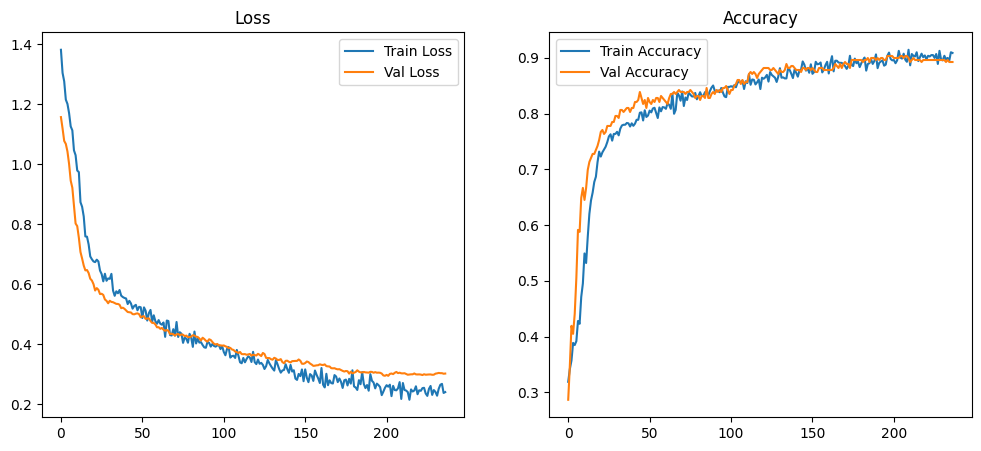

In [3]:
# ======================================
# FIXED SUPER ADVANCED MODEL TRAINING (No PCA)
# ======================================

# -----------------------------
# 1️⃣ Convert augmented lists to arrays
# -----------------------------
X_mel_augmented = np.array(X_mel_augmented)
X_tab_augmented = np.array(X_tab_augmented)
y_augmented = np.array(y_augmented)

# -----------------------------
# 2️⃣ Train-validation split (85% train, 15% validation)
# -----------------------------
X_mel_aug_train, X_mel_aug_val, X_tab_aug_train, X_tab_aug_val, y_aug_train, y_aug_val = train_test_split(
    X_mel_augmented, X_tab_augmented, y_augmented,
    test_size=0.15,
    stratify=y_augmented,
    random_state=42
)

# -----------------------------
# 3️⃣ Flatten MFCC features
# -----------------------------
X_mel_aug_train_flat = X_mel_aug_train.reshape(X_mel_aug_train.shape[0], -1)
X_mel_aug_val_flat   = X_mel_aug_val.reshape(X_mel_aug_val.shape[0], -1)

print(f"✅ Flattened MFCC features: Train {X_mel_aug_train_flat.shape}, Val {X_mel_aug_val_flat.shape}")

# -----------------------------
# 4️⃣ Create Fixed Super Advanced Model
# -----------------------------
num_classes = 3

def create_fixed_super_advanced_model(tabular_dim, pretrained_dim, num_classes):
    """Fixed super advanced model"""
    
    pretrained_input = tf.keras.Input(shape=(pretrained_dim,), name='pretrained_features')
    x_pre = layers.Dense(1024, activation='relu')(pretrained_input)
    x_pre = layers.BatchNormalization()(x_pre)
    x_pre = layers.Dropout(0.4)(x_pre)
    x_pre = layers.Dense(512, activation='relu')(x_pre)
    x_pre = layers.BatchNormalization()(x_pre)
    x_pre = layers.Dropout(0.3)(x_pre)
    x_pre = layers.Dense(256, activation='relu')(x_pre)
    x_pre = layers.BatchNormalization()(x_pre)
    x_pre = layers.Dropout(0.2)(x_pre)
    
    tabular_input = tf.keras.Input(shape=(tabular_dim,), name='tabular_input')
    x_tab = layers.Dense(256, activation='relu')(tabular_input)
    x_tab = layers.BatchNormalization()(x_tab)
    x_tab = layers.Dropout(0.3)(x_tab)
    x_tab = layers.Dense(128, activation='relu')(x_tab)
    x_tab = layers.BatchNormalization()(x_tab)
    x_tab = layers.Dropout(0.2)(x_tab)
    x_tab = layers.Dense(64, activation='relu')(x_tab)
    
    combined = layers.concatenate([x_pre, x_tab])
    x = layers.Dense(512, activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    residual1 = layers.Dense(512, activation='relu')(x)
    residual1 = layers.BatchNormalization()(residual1)
    x = layers.add([x, residual1])
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    residual2 = layers.Dense(256, activation='relu')(x)
    residual2 = layers.BatchNormalization()(residual2)
    x = layers.add([x, residual2])
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[tabular_input, pretrained_input], outputs=output, name='fixed_super_advanced_model')
    return model

super_model = create_fixed_super_advanced_model(
    tabular_dim=X_tab_aug_train.shape[1],
    pretrained_dim=X_mel_aug_train_flat.shape[1],
    num_classes=num_classes
)

super_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model created and compiled!")
super_model.summary()

# -----------------------------
# 5️⃣ Compute class weights
# -----------------------------
class_weights = compute_class_weight('balanced', classes=np.unique(y_aug_train), y=y_aug_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"✅ Class weights: {class_weight_dict}")

# -----------------------------
# 6️⃣ Callbacks
# -----------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, min_lr=1e-8, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('fixed_super_advanced_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# -----------------------------
# 7️⃣ Train the model
# -----------------------------
super_history = super_model.fit(
    [X_tab_aug_train, X_mel_aug_train_flat],
    y_aug_train,
    batch_size=16,
    epochs=300,
    validation_data=([X_tab_aug_val, X_mel_aug_val_flat], y_aug_val),
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

# -----------------------------
# 8️⃣ Evaluate on validation
# -----------------------------


super_model.load_weights('fixed_super_advanced_model.h5')
super_pred = super_model.predict([X_tab_aug_val, X_mel_aug_val_flat])
super_accuracy = accuracy_score(y_aug_val, np.argmax(super_pred, axis=1))
print(f"\n🎯 Validation Accuracy: {super_accuracy:.4f}")

# -----------------------------
# 9️⃣ Plot train / validation metrics
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(super_history.history['loss'], label='Train Loss')
plt.plot(super_history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(super_history.history['accuracy'], label='Train Accuracy')
plt.plot(super_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


In [4]:
# ======================================
# Prepare test tabular features
# ======================================

# 1️⃣ Select tabular features from test_df
tab_features = ['age', 'gender', 'tbContactHistory', 'wheezingHistory', 
                'phlegmCough', 'familyAsthmaHistory', 'feverHistory', 
                'coldPresent', 'packYears']

X_tab_test = test_df[tab_features].values

# 2️⃣ Apply the same Iterative Imputer as training
X_tab_test_imputed = iterative_imputer.transform(X_tab_test)

# 3️⃣ Apply the same StandardScaler as training
X_tab_test_scaled = scaler_tab.transform(X_tab_test_imputed)

# 4️⃣ Reshape test audio features
X_audio_test_fixed = np.array(X_audio_test)  # Ensure it's np.array
X_audio_test_flat = X_audio_test_fixed.reshape(X_audio_test_fixed.shape[0], -1)

# 5️⃣ Predict
super_pred_test = super_model.predict([X_tab_test_scaled, X_audio_test_flat], verbose=1)
y_pred_test = np.argmax(super_pred_test, axis=1)

# 6️⃣ Display results
test_results_df = pd.DataFrame({
    'candidateID': test_df['candidateID'],
    'predicted_disease': y_pred_test
})

print("🎯 Sample predictions on test data:")
print(test_results_df.head(10))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
🎯 Sample predictions on test data:
     candidateID  predicted_disease
0  136bac9a3e081                  0
1  b121e45942a46                  1
2  6b6853c07e4fb                  2
3  71de185eac888                  2
4  25deed742f133                  0
5  1de4591779d31                  2
6  102efeabb10a5                  1
7  522d1f8600a13                  0
8  e41530046a74e                  1
9  6337b96a160eb                  0
